In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.stats import ortho_group
import sys
sys.path.append('..')
from riccati import riccati_, riccati_solve
from neurosim.models.ssr import StateSpaceRealization as SSR

In [3]:
# Entropy of a binary string drawn from a binomial distribution

In [4]:
import itertools
from tqdm import tqdm

### Bialek Toy

In [81]:
# Set parameters
# Want to calculate H(2N) - 2 H(N)
def gen_strings(n):
    # Generate all binary strings of length n
    strings = []
    for k in range(0, n + 1):
        subsets = itertools.combinations(np.arange(n), k)
        # Each subset gives possible locations of a 1
        for subset in subsets:
            string_ = np.zeros(n)
            if len(subset) > 0:
                string_[list(subset)] = 1
            strings.append(string_)
    return strings
                        
def get_probs(J, strings):
    # Evaluate the probability of each
    probs = [boltzmann(J, sigma) for sigma in strings]
    return probs/sum(probs)
    
# Boltzmann distribution
def boltzmann(J, sigma):
    return np.exp(-1 * sigma @ J @ sigma)    

def calc_entropy(probs):
    return -1 * sum([prob * np.log(prob) for prob in probs])

n = np.arange(2, 24, 2)

H = np.zeros((n.size, 3))
PI = np.zeros((n.size, 3))

for i, n_ in tqdm(enumerate(n)):
    # Use completely uncorrelated J, n.n. J, and power law decaying J
    J1 = np.zeros((n_, n_))
    J2 = np.zeros((n_, n_))
    for k in range(n_):
        for l in range(n_):
            if k == l - 1:
                J2[k, l] = 1

    J3 = np.zeros((n_, n_))
    for k in range(n_):
        for l in range(n_):
            if k == l:
                continue
            else:
                J3[k, l] = 1/(k -l)**2

    # Generate all strings of length n_
    strings = gen_strings(n_)
    strings_ = gen_strings(n_//2)
    
    # Case 1: No coupling
    probs = get_probs(J1, strings)
    H[i, 0] = calc_entropy(probs)
    
    probs_ = get_probs(J1[0:n_//2, 0:n_//2], strings_)
    H_ = calc_entropy(probs_)
    PI[i, 0] = H[i, 0] - 2 * H_   

    # Case 2: n.n coupling
    probs = get_probs(J2, strings)
    H[i, 1] = calc_entropy(probs)
    
    probs_ = get_probs(J2[0:n_//2, 0:n_//2], strings_)
    H_ = calc_entropy(probs_)
    PI[i, 1] = H[i, 1] - 2 * H_    
    
    # Case 3: power law coupling
    probs = get_probs(J3, strings)
    H[i, 2] = calc_entropy(probs)
    
    probs_ = get_probs(J3[0:n_//2, 0:n_//2], strings_)
    H_ = calc_entropy(probs_)
    PI[i, 2] = 2 * H_  - H[i, 2]

11it [01:25,  7.74s/it]


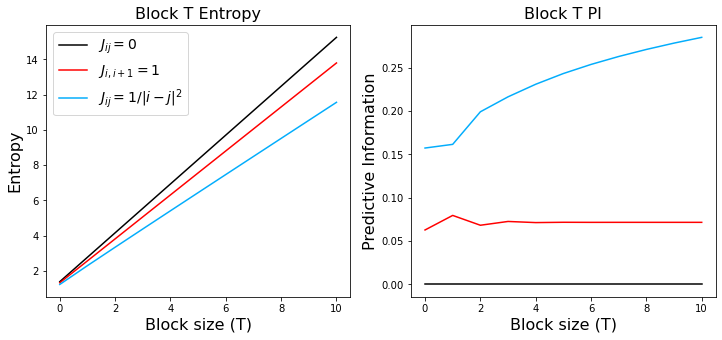

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(H[:, 0], color='black')
ax[0].plot(H[:, 1], color='r')
ax[0].plot(H[:, 2], color='#03adfc')

ax[1].plot(-1 * PI[:, 0], color='black')
ax[1].plot(-1 * PI[:, 1], color='r')
ax[1].plot(PI[:, 2], color='#03adfc')

ax[0].set_title('Block T Entropy', fontsize=16)
ax[1].set_title('Block T PI', fontsize=16)

ax[0].set_xlabel('Block size (T)', fontsize=16)
ax[1].set_xlabel('Block size (T)', fontsize=16)

ax[0].set_ylabel('Entropy', fontsize=16)
ax[1].set_ylabel('Predictive Information', fontsize=16)

ax[0].legend([r'$J_{ij} = 0$', r'$J_{i, i + 1} = 1$', r'$J_{ij} = 1/|i - j|^2$'], fontsize=14)

fig.savefig('Ising_toy.pdf', bbox_inches='tight', pad_inches=0)

In [97]:
# Return the mode of each Boltzmann distribution
n_ = 20

J1 = np.zeros((n_, n_))
J2 = np.zeros((n_, n_))
for k in range(n_):
    for l in range(n_):
        if k == l - 1:
            J2[k, l] = 1

J3 = np.zeros((n_, n_))
for k in range(n_):
    for l in range(n_):
        if k == l:
            continue
        else:
            J3[k, l] = 1/(k -l)**2

# Generate all strings of length n_
strings = gen_strings(n_)

# Case 1: No coupling
probs1 = get_probs(J1, strings)

# Case 2: n.n coupling
probs2 = get_probs(J2, strings)

# Case 3: power law coupling
probs3 = get_probs(J3, strings)

In [99]:
strings[np.random.choice(np.arange(len(strings)))]

array([1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0.])

In [100]:
np.argmax(probs2)

0

array([      0,  231188,  307590, ..., 1048555, 1048574, 1048575])

In [113]:
strings[np.argsort(probs2)[::-1][0]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [117]:
strings[np.argsort(probs3)[::-1][3]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])

### Non-normality

In [ ]:
# Using a 2x2 example, demonstrate how you get transients 

In [ ]:
# Parameterize using the eigenvalues and angle between eigenvectors

In [16]:
l1 = 0.9
l2 = 0.5
phi = np.linspace(np.pi/32, np.pi/2)

t = 50
norm_trajectories = np.zeros((phi.size, t))

for i, phi_ in enumerate(phi):
    
    A = np.array([[l1, np.abs(l2 - l1) * 1/np.tan(phi_)], [0, l2]])
    norm_trajectories[i, :] = [np.linalg.norm(np.linalg.matrix_power(A, k)) for k in range(t)]    

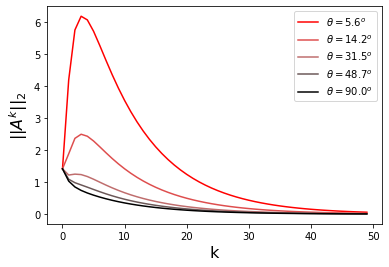

In [140]:
plt.plot(norm_trajectories[0, :], label=r'$\theta = %.1f^o$' % (180/np.pi * phi[0]), color='r')
plt.plot(norm_trajectories[5, :], label=r'$\theta = %.1f^o$' % (180/np.pi * phi[5]), color='#de4e4e')
plt.plot(norm_trajectories[15, :], label=r'$\theta = %.1f^o$' % (180/np.pi * phi[15]), color='#bf6d6d')
plt.plot(norm_trajectories[25, :], label=r'$\theta = %.1f^o$' % (180/np.pi * phi[25]), color='#6b5858')
plt.plot(norm_trajectories[-1, :], label=r'$\theta = %.1f^o$' % (180/np.pi * phi[-1]), color='black')
plt.legend()
plt.ylabel(r'$||A^k||_2$', fontsize=16)
plt.xlabel('k', fontsize=16)
plt.savefig('transient_amplification.pdf', bbox_inches='tight', pad_inches=0)

In [141]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from sklearn.decomposition import PCA
from dca.dca import DynamicalComponentsAnalysis as DCA

In [ ]:
# Now demonstrate the divergence between PCA and DCA 2 -> 1 subspaces as we vary phi

In [147]:
l1 = 0.9
l2 = 0.5
phi = np.linspace(np.pi/32, np.pi/2)

pca_dca_angle = np.zeros(phi.size)

for i, phi_ in tqdm(enumerate(phi)):
    A = np.array([[l1, np.abs(l2 - l1) * 1/np.tan(phi_)], [0, l2]])
    
    ssm = SSR(A = A, B=np.eye(2), C=np.eye(2))
    y = ssm.trajectory(int(1e5))
    
    pcamodel = PCA().fit(y)
    dcamodel = DCA(T=5, d=1).fit(y)
    pca_dca_angle[i] = np.arccos(np.abs(pcamodel.components_[0, :] @ dcamodel.coef_.ravel()))

50it [00:34,  1.47it/s]


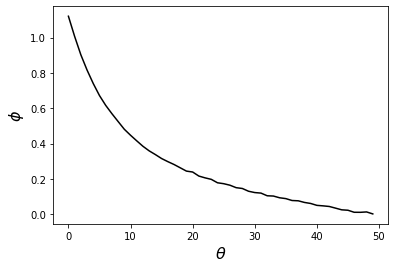

In [151]:
plt.plot(pca_dca_angle, color='k')plt.xlabel(r'$\theta$', fontsize=16)
plt.ylabel(r'$\phi$', fontsize=16)
plt.savefig('dca_pca_angle.pdf', bbox_inches='tight', pad_inches=0)

### Explicity solving 2x2 systems

In [33]:
def left_right_eig(A):
    # Right and left eigenvector decomposition of A
    eigvalsA, RA = scipy.linalg.eig(A)
    eigorder = np.argsort(np.abs(eigvalsA))[::-1]
    RA = RA[:, eigorder]

    eigvalsA, LA = scipy.linalg.eig(A.T)
    eigorder = np.argsort(np.abs(eigvalsA))[::-1]
    LA = LA[:, eigorder]

    eigvalsA = eigvalsA[eigorder]
    
    # Scale each left and right eigenvector to obtain biorthogonality
    for j in range(A.shape[0]):
        inner_product = RA[:, j] @ LA[:, j]
        RA[:, j] /= np.sqrt(inner_product)
        LA[:, j] /= np.sqrt(inner_product)
    
    # Verify correct decomposition
    Aproj = []
    for i in range(A.shape[0]):
        Aproj.append(np.outer(RA[:,i], LA[:, i]))
        
    Areconstr = sum([eigvalsA[i] * Aproj[i] for i in range(A.shape[0])])
    assert(np.allclose(np.abs(Areconstr - A),
                       np.zeros(A.shape)))    
    return eigvalsA, RA, LA

In [ ]:
# Return the state covariance in the eigenbasis of A
def W_Aeig

In [15]:
l1 = 0.9
l2 = 0.5
phi = np.pi/8

A = np.array([[l1, np.abs(l2 - l1) * 1/np.tan(phi)], [0, l2]])

In [16]:
eig, R, L = left_right_eig(A)

NameError: name 'left_right_eig' is not defined

In [17]:
R[:, 0] @ R[:, 1]

NameError: name 'R' is not defined

In [23]:
eig[0] * np.outer(L[0, :], R[:, 0]) + eig[1] * np.outer(L[1, :], R[:, 1])

array([[-0.40698089+0.j,  0.04877258+0.j],
       [-0.49759236+0.j,  0.04900857+0.j]])

In [18]:
A

array([[0.9       , 0.96568542],
       [0.        , 0.5       ]])

In [83]:
A = np.array([[0.85, 0], [0, 0.9]])

In [84]:
ssm2 = SSR(A = A, B=np.eye(2), C=np.array([1, 0])[np.newaxis, :])
ssm1 = SSR(A=A, B=np.array([1, 0])[:, np.newaxis], C=np.array([1, 0])[np.newaxis, :])

In [85]:
ssm2.solve_min_phase()

In [47]:
ssm1.solve_min_phase()

In [48]:
ssm1.Bmin

DeviceArray([[0.9000001],
             [0.       ]], dtype=float32)

In [86]:
ssm2.Bmin

DeviceArray([[0.85],
             [0.  ]], dtype=float32)

In [51]:
ssm2.P - ssm2.Pmin

DeviceArray([[2.061266  , 0.54948735],
             [0.54948735, 1.2845063 ]], dtype=float32)

In [49]:
ssm2.Bmin @ ssm2.Bmin.T

DeviceArray([[2.7613626 , 0.3179966 ],
             [0.3179966 , 0.03662026]], dtype=float32)

In [53]:
# What happened to Shaked formula? Doesn't seem to line up above

In [ ]:
# Can we verify Bode amplitude-gain relationship is satisfied for minimum phase system?
# Can we see visually that energy in impulse response is contained near the origin?

In [ ]:
# Cepstrum coefficient expansion...Anything to be learned?

In [37]:
ssm2.Cbar.shape

(1, 2)

In [39]:
P = riccati_solve(A, C = np.array([1, 0])[np.newaxis, :], Cbar = ssm2.Cbar, L0=ssm2.cov, tol=1e-8)

In [74]:
n = 1000
W = np.random.normal(size=(n, n))
Q = np.random.normal(size=(n, n))

In [75]:
from neurosim.utils.symbols import gen_toeplitz

In [73]:
T1 = gen_toeplitz(ssm2.transfer_fn, 10)
T2 = gen_toeplitz(ssm2.tranfer_fn_conj, 10)

> /home/akumar/nse/neurosim/neurosim/utils/symbols.py(94)gen_toeplitz()
     92 
     93     pdb.set_trace()
---> 94     for j in range(maxlag):
     95         phi_inv_mirror[j, ...] = phi_inv[-j, ...].T
     96 

ipdb> maxlag
10
ipdb> phi_inv.shape
(11, 1, 2)
ipdb> phi_inv_mirror.shape
(10, 1, 2)
ipdb> quit()


BdbQuit: 

In [70]:
np.trace(W @ Q - Q @ W)

-4.547473508864641e-13

In [69]:
np.trace(W @ (W @ Q - Q @ W) - (W @ Q - Q @ W) @ W)

7.275957614183426e-12

In [67]:
np.sum(np.linalg.eigvals(W @ Q @ np.linalg.inv(W) @ np.linalg.inv(Q) - np.eye(n)))

KeyboardInterrupt: 

In [61]:
np.linalg.slogdet(scipy.linalg.expm(W) @ scipy.linalg.expm(Q) @ scipy.linalg.expm(-W) @ scipy.linalg.expm(-Q))

(-1.0, 85564.13308261627)

In [62]:
np.trace(W @ Q - Q @ W)

1.2505552149377763e-12

### Is the exponential of an upper diagonal Toeplitz matrix the Toeplitz matrix with exponential symbol?

In [18]:
def gen_ut_toeplitz(n, a):
    T = np.zeros((n, n))
#    np.fill_diagonal(T, np.log(-1/a))
    for j in range(1, n):
        for i in range(j):
            T[i, j] = 1/np.abs(i - j) * np.power(a, np.abs(i - j))
    return T

In [ ]:
# How do we get Laurent series coefficients of log((z - A)^{-1})?

In [42]:
z = 1.0 * np.exp(1j * np.pi/7)
A = np.array([[0.5, 0.75], [0, 0.5]])

In [43]:
scipy.linalg.logm(np.linalg.inv(z * np.eye(A.shape[0]) - A))

array([[0.52629708-0.82480372j, 0.86160409-0.93233174j],
       [0.        +0.j        , 0.52629708-0.82480372j]])

In [ ]:
# Check against the power series -> Matrix case lines up with the scalar case

In [44]:
-scipy.linalg.logm(z * np.eye(2)) + sum([np.linalg.matrix_power(A, j)/(j * z**j) for j in range(1, 50)])

array([[0.52629708-0.82480372j, 0.86160409-0.93233174j],
       [0.        +0.j        , 0.52629708-0.82480372j]])

In [50]:
def gen_ut_block_toeplitz(n, A):
    T = np.zeros((n * A.shape[0], n*A.shape[0]))
    for j in range(1, n):
        for i in range(j):
            T[i*A.shape[0]:(i + 1)*A.shape[0], j*A.shape[0]:(j + 1)*A.shape[0]] = \
            np.linalg.matrix_power(A, np.abs(i - j))/np.abs(i - j)
    return T

In [81]:
def gen_ut_block_toeplitz2(n, A):
    T = np.zeros((n * A.shape[0], n*A.shape[0]))

    # Diagonal
    for i in range(n):
        T[i * A.shape[0]:(i + 1)*A.shape[0], i * A.shape[0]:(i + 1)*A.shape[0]] = np.eye(2)
    
    for j in range(1, n):
        for i in range(j):
            T[i*A.shape[0]:(i + 1)*A.shape[0], j*A.shape[0]:(j + 1)*A.shape[0]] = \
            np.linalg.matrix_power(A, np.abs(i - j))
    return T

In [26]:
T = gen_ut_toeplitz(100, 0.5)

In [28]:
scipy.linalg.expm(T)[0, :]

array([1.00000000e+00, 5.00000000e-01, 2.50000000e-01, 1.25000000e-01,
       6.25000000e-02, 3.12500000e-02, 1.56250000e-02, 7.81250000e-03,
       3.90625000e-03, 1.95312500e-03, 9.76562500e-04, 4.88281250e-04,
       2.44140625e-04, 1.22070312e-04, 6.10351562e-05, 3.05175781e-05,
       1.52587891e-05, 7.62939453e-06, 3.81469727e-06, 1.90734863e-06,
       9.53674316e-07, 4.76837158e-07, 2.38418579e-07, 1.19209290e-07,
       5.96046448e-08, 2.98023224e-08, 1.49011612e-08, 7.45058060e-09,
       3.72529030e-09, 1.86264515e-09, 9.31322575e-10, 4.65661287e-10,
       2.32830644e-10, 1.16415322e-10, 5.82076609e-11, 2.91038305e-11,
       1.45519152e-11, 7.27595762e-12, 3.63797881e-12, 1.81898940e-12,
       9.09494702e-13, 4.54747351e-13, 2.27373676e-13, 1.13686838e-13,
       5.68434189e-14, 2.84217095e-14, 1.42108547e-14, 7.10542737e-15,
       3.55271368e-15, 1.77635684e-15, 8.88178422e-16, 4.44089211e-16,
       2.22044606e-16, 1.11022303e-16, 5.55111514e-17, 2.77555757e-17,
      

In [27]:
T[0, :]

array([0.00000000e+00, 5.00000000e-01, 1.25000000e-01, 4.16666667e-02,
       1.56250000e-02, 6.25000000e-03, 2.60416667e-03, 1.11607143e-03,
       4.88281250e-04, 2.17013889e-04, 9.76562500e-05, 4.43892045e-05,
       2.03450521e-05, 9.39002404e-06, 4.35965402e-06, 2.03450521e-06,
       9.53674316e-07, 4.48787914e-07, 2.11927626e-07, 1.00386770e-07,
       4.76837158e-08, 2.27065313e-08, 1.08372081e-08, 5.18301259e-09,
       2.48352687e-09, 1.19209290e-09, 5.73121584e-10, 2.75947430e-10,
       1.33046082e-10, 6.42291431e-11, 3.10440858e-11, 1.50213318e-11,
       7.27595761e-12, 3.52773703e-12, 1.71199003e-12, 8.31538013e-13,
       4.04219867e-13, 1.96647503e-13, 9.57362844e-14, 4.66407539e-14,
       2.27373675e-14, 1.10913988e-14, 5.41365894e-15, 2.64387995e-15,
       1.29189588e-15, 6.31593543e-16, 3.08931624e-16, 1.51179305e-16,
       7.40148683e-17, 3.62521804e-17, 1.77635684e-17, 8.70763157e-18,
       4.27008856e-18, 2.09476042e-18, 1.02798428e-18, 5.04646829e-19,
      

In [51]:
T = gen_ut_block_toeplitz(100, A)

In [53]:
eT = scipy.linalg.expm(T)

In [62]:
eT[2:4, 6:8]

array([[0.25, 0.75],
       [0.  , 0.25]])

In [60]:
np.linalg.matrix_power(A, 3)

array([[0.125 , 0.5625],
       [0.    , 0.125 ]])

In [ ]:
# Commutator identity

In [82]:
Tepsi = gen_ut_block_toeplitz2(100, A)
Tpsi = gen_ut_block_toeplitz(100, A)

In [83]:
Tepsi[0, 0:20]

array([1.        , 0.        , 0.5       , 0.75      , 0.25      ,
       0.75      , 0.125     , 0.5625    , 0.0625    , 0.375     ,
       0.03125   , 0.234375  , 0.015625  , 0.140625  , 0.0078125 ,
       0.08203125, 0.00390625, 0.046875  , 0.00195312, 0.02636719])

In [84]:
scipy.linalg.expm(Tpsi)[0, 0:20]

array([1.        , 0.        , 0.5       , 0.75      , 0.25      ,
       0.75      , 0.125     , 0.5625    , 0.0625    , 0.375     ,
       0.03125   , 0.234375  , 0.015625  , 0.140625  , 0.0078125 ,
       0.08203125, 0.00390625, 0.046875  , 0.00195312, 0.02636719])

In [74]:
Tepsi

array([[1.00000000e+00, 0.00000000e+00, 5.00000000e-01, ...,
        4.73316543e-30, 1.59365839e-32, 2.36658272e-30],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.21984043e-32, 0.00000000e+00, 1.59365839e-32],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        9.46633086e-30, 3.21984043e-32, 4.73316543e-30],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [86]:
Tpsiplus = gen_ut_block_toeplitz(100, A.T).T

In [87]:
Tpsiplus

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e-01, 7.50000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 3.21984043e-32, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59365839e-32, 2.36658272e-30, 3.21984043e-32, ...,
        7.50000000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.59365839e-32, 0.00000000e+00, ...,
        5.00000000e-01, 0.00000000e+00, 0.00000000e+00]])

In [63]:
psi_minus = gen_ut_block_toeplitz(100, A)
psi_plus = gen_ut_block_toeplitz(100, A.T).T

In [64]:
P = scipy.linalg.expm(psi_minus) @ scipy.linalg.expm(psi_plus) @ scipy.linalg.expm(-psi_minus) @ scipy.linalg.expm(-psi_plus)

### Does Bode gain phase and outer function integral relation hold element by element?

In [99]:
# Take a multivariate, minimum phase transfer function and evaluate Bode and Szego relation element by element
A = 1/(2 * np.sqrt(10)) * np.random.normal(size=(10, 10))
B = np.eye(10)
C = ortho_group.rvs(10)[:, 0:2].T
ssm = SSR(A, B, C)

In [100]:
ssm.solve_min_phase()

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
# Demonstrate that the energy is concentrated closer to the beginning of the signal in the min phase vs. 
# non min phase realization

In [119]:
x1 = np.array([C @ np.linalg.matrix_power(A, k) @ B @ B.T @ np.linalg.matrix_power(A.T, k) @ C.T for k in range(20)])
x2 = np.array([C @ np.linalg.matrix_power(A, k) @ ssm.Bmin @ ssm.Bmin.T @ np.linalg.matrix_power(A.T, k) @ C.T
               + ssm.Dmin @ ssm.Dmin.T * (1 * k == 0) for k in range(20)])

In [113]:
np.cumsum(x1, axis=0).shape

(20, 2, 2)

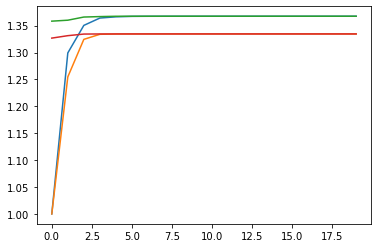

In [121]:
plt.plot(np.cumsum(x1, axis=0)[:, 0, 0])
plt.plot(np.cumsum(x1, axis=0)[:, 1, 1])
#plt.plot(np.cumsum(x1, axis=0)[:, 0, 1])

plt.plot(np.cumsum(x2, axis=0)[:, 0, 0])
plt.plot(np.cumsum(x2, axis=0)[:, 1, 1])
#plt.plot(np.cumsum(x2, axis=0)[:, 0, 1])

In [122]:
# Elementwise bode gain phase relationship - yes, move on

### Are the left singular vectors of the forward and reverse time minimum phase realizations the same?

### Answer: A naive application of SVD will yield vectors with different phases, but one can verify that the phase function is given by the expected expression

In [21]:
A = 1/(2 * np.sqrt(10)) * np.random.normal(size=(10, 10))
B = np.eye(10)
C = ortho_group.rvs(10)[:, 0:2].T
ssm = SSR(A, B, C)

In [22]:
# First verify that the minimum/maximum phase realizations combine to give the spectral density

In [23]:
z = np.exp(1j * np.linspace(0, 2*np.pi))

In [24]:
phi = ssm.spectral_density(z)

In [25]:
phi0 = ssm.minphase_transfer_fn(z) @ ssm.minphase_transfer_fn_conj(z)

In [26]:
phi1 = ssm.maxphase_acausal_transfer_fn(z) @ ssm.maxphase_acausal_transfer_fn_conj(z)

In [30]:
np.allclose(phi1, phi0)

True

In [ ]:
# Be careful, as SVD and eigh/eig all return eigenvectors that differ in phase

In [31]:
Wm = ssm.minphase_transfer_fn(z)
Wp = ssm.maxphase_acausal_transfer_fn(z)

In [37]:
Wmc = ssm.minphase_transfer_fn_conj(z)
WPc = ssm.maxphase_acausal_transfer_fn_conj(z)

In [180]:
Xm, _, Vmh = scipy.linalg.svd(Wm[11, ...])
Xp, _, Vph = scipy.linalg.svd(Wp[11, ...])

In [176]:
Um, _ = scipy.linalg.polar(Wm[11, ...], 'left')
Up, _ = scipy.linalg.polar(Wp[11, ...], 'left')

In [184]:
Xp

array([[ 0.18583503+0.05587963j,  0.9386665 +0.28503987j],
       [-0.7640138 +0.61532575j,  0.15146406-0.12130889j]],
      dtype=complex64)

In [183]:
Xm

array([[ 0.18337825-0.06347839j,  0.941231  -0.27645415j],
       [-0.2592353 +0.9461183j ,  0.06012208-0.18450592j]],
      dtype=complex64)

In [182]:
Xp @ Vph

array([[ 0.95569336+0.2900763j ,  0.02522337+0.04323457j],
       [-0.03865995+0.03179395j,  0.9969654 +0.05961844j]],
      dtype=complex64)

In [177]:
np.linalg.inv(Up) @ Um

array([[ 0.8312602 -0.54711634j, -0.08412408-0.05092666j],
       [ 0.03070991-0.09341995j,  0.98717254-0.1257781j ]],
      dtype=complex64)

In [173]:
np.linalg.inv(Wp[11, ...]) @ Wm[11, ...]

array([[ 0.8312602 -0.5471162j , -0.08412407-0.05092669j],
       [ 0.03070995-0.09341995j,  0.9871726 -0.12577808j]],
      dtype=complex64)

In [174]:
np.linalg.inv(Vph) @ Vmh

array([[ 0.9951877 -5.7256938e-10j, -0.03232371-9.2503294e-02j],
       [ 0.07251844-6.5899573e-02j,  0.87478215+4.7450498e-01j]],
      dtype=complex64)

In [178]:
Um

array([[ 0.9579489 -0.28277522j, -0.03528643-0.03356524j],
       [ 0.02144479-0.04372504j,  0.9965469 -0.06724854j]],
      dtype=complex64)

In [179]:
Up

array([[ 0.95569336+0.2900763j ,  0.02522337+0.04323457j],
       [-0.03865995+0.03179395j,  0.9969654 +0.05961844j]],
      dtype=complex64)